In [1]:

!tar -xzvf "/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/dataset_purchase.tgz" -C "/content/"

!mv "/content/dataset_purchase" "/content/dataset_purchase.csv"

dataset_purchase


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import numpy as np
import random
import torch
import os
import pandas as pd
import numpy as np

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


class TargetModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TargetModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.output(x)
        return x


def create_df_with_membership_status_using_model_outputs(model, member_df, non_member_df):

    ''' create a dataframe from the outputs of a model
    and add a column refering to the membership status of each record '''

    member_tensor = torch.tensor(member_df.values, dtype=torch.float32)
    non_member_tensor = torch.tensor(non_member_df.values, dtype=torch.float32)

    # use the provided model to generate outputs
    model.eval()
    member_outputs =  F.softmax(model(member_tensor), dim=1)
    non_member_outputs = F.softmax(model(non_member_tensor), dim=1)

    in_df = pd.DataFrame(member_outputs.detach().numpy())
    in_df['membership'] = True

    out_df = pd.DataFrame(non_member_outputs.detach().numpy())
    out_df['membership'] = False

    concatenated_df = pd.concat([in_df, out_df])

    return concatenated_df


def get_mia_stats(member_df, non_member_df, atk_model, tgt_model):
    X_member_df = member_df.copy()
    X_non_member_df = non_member_df.sample(n=len(X_member_df), replace=False).drop(columns=non_member_df.columns[0], axis=1)

    dataset_from_target_model_outputs = create_df_with_membership_status_using_model_outputs(tgt_model, X_member_df, X_non_member_df)

    X_attack = dataset_from_target_model_outputs.drop(columns=['membership'])
    y_attack = dataset_from_target_model_outputs['membership']

    y_attack_pred = atk_model.predict(X_attack)

    accuracy = atk_model.score(X_attack, y_attack)

    f1 = f1_score(y_attack, y_attack_pred)

    # print(f"Test F1 Score: {f1:.4f}")
    # print(f"Test Accuracy: {accuracy:.4f}")

    return f1, accuracy

df = pd.read_csv('/content/dataset_purchase.csv')

set_seed(150)

target_dataset_head_rows = 50_000
train_df, test_df = train_test_split(df.head(target_dataset_head_rows), test_size=0.2)

retain_df, forget_df = train_test_split(train_df, test_size=0.1)

Random seed set as 150


In [31]:
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score



def unlearn_target_nn(model, forget_loader, val_loader, criterion, optimizer, epochs, max_val_loss=0.01 ):

    best_val_loss = float('inf')
    patience_counter = 0
    forget_f1s = []
    forget_accs = []
    retain_f1s = []
    retain_accs = []
    batch_ids = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        model.train()
        running_loss = 0.0

        for batch_idx, (x_forget, y_forget) in enumerate(forget_loader):
            optimizer.zero_grad()
            outputs_forget = model(x_forget)
            loss_forget = -criterion(outputs_forget, y_forget)
            loss_forget.backward()
            optimizer.step()

            running_loss += loss_forget.item()

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
            val_loss /= len(val_loader)

            if val_loss > max_val_loss:
                print(f"Early stopping because validation loss exceeded the maximum allowed threshold: {max_val_loss:.4f}")
                return forget_f1s, forget_accs, retain_f1s, retain_accs, batch_ids

            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(forget_loader)}] - Forget Loss: {loss_forget.item():.4f} - Validation Loss: {val_loss:.4f}")
                f1_forget, acc_forget = get_mia_stats(X_forget_df, never_seen_before_data_df, attack_model, model)
                f1_retain, acc_retain = get_mia_stats(X_retain_df, never_seen_before_data_df, attack_model, model)
                forget_f1s.append(f1_forget)
                forget_accs.append(acc_forget)
                retain_f1s.append(f1_retain)
                retain_accs.append(acc_retain)
                print('forget stats', f1_forget, acc_forget)
                print('retain stats', f1_retain, acc_retain)
                batch_ids.append(f'{epoch}.{batch_idx}')

    return forget_f1s, forget_accs, retain_f1s, retain_accs, batch_ids


set_seed(42)

# load the trained target model
FOLDER_NAME = 'Unlearning/full_data_target_model_seed_150'
FOLDER_PATH = f'/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/{FOLDER_NAME}'
target_model = torch.jit.load(f'{FOLDER_PATH}/full_data_target_model_seed_150.pt')


print(retain_df.shape, forget_df.shape)

# split the retain into train and test for the training process
target_model_df = retain_df.copy()
X = target_model_df.drop(columns=target_model_df.columns[0], axis=1)
y = target_model_df.iloc[:, 0] - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape)

# prepare forget data to feed them into unlearning
X_forget = forget_df.drop(columns=forget_df.columns[0], axis=1)
y_forget = forget_df.iloc[:, 0] - 1

# for doing the mia
folder_name = f'Unlearning'
folder_path = f"/content/drive/MyDrive/Python/Diplomatiki/MIA_purchase_dataset/{folder_name}"
attack_model = joblib.load(folder_path + "/attack_model_pre_trained.joblib")
never_seen_before_data_df = df.iloc[90_000:]

X_retain = retain_df.drop(columns=retain_df.columns[0], axis=1)

X_forget_df = X_forget.copy()
X_retain_df = X_retain.copy()


if __name__ == "__main__":

    # Set the parameters
    n_features = X_train.shape[1]
    n_classes = len(set(y_train))

    # Convert data to PyTorch tensors
    X_forget_tensor = torch.tensor(X_forget.values, dtype=torch.float32)
    y_forget_tensor = torch.tensor(y_forget.values, dtype=torch.long)

    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    hidden_size = 128
    learning_rate = 0.003
    epochs = 50
    batch_size = 32

    forget_data = TensorDataset(X_forget_tensor, y_forget_tensor)
    forget_loader = DataLoader(forget_data, batch_size=batch_size, shuffle=True)

    test_data = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(target_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-7)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

    forget_f1s, forget_accs, retain_f1s, retain_accs, batch_ids = unlearn_target_nn(target_model, forget_loader, test_loader, criterion, optimizer, epochs, max_val_loss=0.4)


Random seed set as 42
(36000, 601) (4000, 601)
(28800, 600) (7200, 600)


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Batch [1/125] - Forget Loss: -0.0039 - Validation Loss: 0.0041


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.0s


forget stats 0.776630083925113 0.7405
retain stats 0.7757458636032877 0.7389027777777778
Epoch [1/50], Batch [11/125] - Forget Loss: -0.0053 - Validation Loss: 0.0041


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7762959776295978 0.74
retain stats 0.7740537967150679 0.7363333333333333
Epoch [1/50], Batch [21/125] - Forget Loss: -0.0036 - Validation Loss: 0.0041


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.774020397208803 0.736875
retain stats 0.7737860150841047 0.7358888888888889
Epoch [1/50], Batch [31/125] - Forget Loss: -0.0039 - Validation Loss: 0.0041


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


forget stats 0.7744013744228498 0.737375
retain stats 0.77503188965583 0.7379027777777778
Epoch [1/50], Batch [41/125] - Forget Loss: -0.0045 - Validation Loss: 0.0041


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7723916532905297 0.734125
retain stats 0.7743357034813783 0.7368472222222222
Epoch [1/50], Batch [51/125] - Forget Loss: -0.0026 - Validation Loss: 0.0041


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s


forget stats 0.7711873463717005 0.732375
retain stats 0.774743864665237 0.7373888888888889
Epoch [1/50], Batch [61/125] - Forget Loss: -0.0043 - Validation Loss: 0.0041


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7770481214339541 0.741125
retain stats 0.77482267389879 0.7376527777777778
Epoch [1/50], Batch [71/125] - Forget Loss: -0.0055 - Validation Loss: 0.0041


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.0s


forget stats 0.7735707390325003 0.736125
retain stats 0.7742158534113803 0.7369583333333334
Epoch [1/50], Batch [81/125] - Forget Loss: -0.0036 - Validation Loss: 0.0041


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7724935732647814 0.7345
retain stats 0.7742243209081586 0.7370277777777777
Epoch [1/50], Batch [91/125] - Forget Loss: -0.0056 - Validation Loss: 0.0041


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7698556921432389 0.730875
retain stats 0.7741111906466236 0.7370277777777777
Epoch [1/50], Batch [101/125] - Forget Loss: -0.0044 - Validation Loss: 0.0041


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


forget stats 0.7726833458606249 0.735375
retain stats 0.7738649106482476 0.7367222222222222
Epoch [1/50], Batch [111/125] - Forget Loss: -0.0046 - Validation Loss: 0.0041


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7712264150943396 0.73325
retain stats 0.7736371227484196 0.7364444444444445
Epoch [1/50], Batch [121/125] - Forget Loss: -0.0048 - Validation Loss: 0.0041


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s


forget stats 0.7737839001291434 0.73725
retain stats 0.7730773816620962 0.7356666666666667
Epoch [2/50], Batch [1/125] - Forget Loss: -0.0052 - Validation Loss: 0.0041


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7755014017683847 0.73975
retain stats 0.7739485562800028 0.7370833333333333
Epoch [2/50], Batch [11/125] - Forget Loss: -0.0052 - Validation Loss: 0.0041


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s


forget stats 0.773318988703604 0.736625
retain stats 0.7727484166457939 0.735375
Epoch [2/50], Batch [21/125] - Forget Loss: -0.0044 - Validation Loss: 0.0041


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7725561888375093 0.735625
retain stats 0.7713543899766567 0.7333611111111111
Epoch [2/50], Batch [31/125] - Forget Loss: -0.0037 - Validation Loss: 0.0042


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s


forget stats 0.7693627976829006 0.73125
retain stats 0.7728927671867353 0.7357638888888889
Epoch [2/50], Batch [41/125] - Forget Loss: -0.0045 - Validation Loss: 0.0042


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7694289394589952 0.7315
retain stats 0.7712769129838373 0.7336805555555556
Epoch [2/50], Batch [51/125] - Forget Loss: -0.0047 - Validation Loss: 0.0042


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.770739064856712 0.734
retain stats 0.7702080999261043 0.7322222222222222
Epoch [2/50], Batch [61/125] - Forget Loss: -0.0064 - Validation Loss: 0.0042


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


forget stats 0.7656885842792889 0.7265
retain stats 0.7703654199584697 0.73275
Epoch [2/50], Batch [71/125] - Forget Loss: -0.0037 - Validation Loss: 0.0042


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


forget stats 0.7701782820097245 0.734125
retain stats 0.7701474714908352 0.7326527777777778
Epoch [2/50], Batch [81/125] - Forget Loss: -0.0055 - Validation Loss: 0.0042


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s


forget stats 0.7690645927846188 0.73275
retain stats 0.7695043926661573 0.7318055555555556
Epoch [2/50], Batch [91/125] - Forget Loss: -0.0050 - Validation Loss: 0.0042


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


forget stats 0.7677858145309294 0.731125
retain stats 0.77032182450937 0.7332638888888889
Epoch [2/50], Batch [101/125] - Forget Loss: -0.0050 - Validation Loss: 0.0042


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s


forget stats 0.7655946470969135 0.7285
retain stats 0.7693503449760252 0.7320972222222222
Epoch [2/50], Batch [111/125] - Forget Loss: -0.0054 - Validation Loss: 0.0042


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7666161506819658 0.7305
retain stats 0.7695365348466888 0.7326527777777778
Epoch [2/50], Batch [121/125] - Forget Loss: -0.0060 - Validation Loss: 0.0042


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


forget stats 0.7600991058924917 0.721625
retain stats 0.7681721356597496 0.7309444444444444
Epoch [3/50], Batch [1/125] - Forget Loss: -0.0064 - Validation Loss: 0.0042


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7606727037516172 0.7225
retain stats 0.7675459594025278 0.73025
Epoch [3/50], Batch [11/125] - Forget Loss: -0.0046 - Validation Loss: 0.0042


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.758605851979346 0.7195
retain stats 0.7681966583445361 0.7317777777777777
Epoch [3/50], Batch [21/125] - Forget Loss: -0.0056 - Validation Loss: 0.0043


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s


forget stats 0.7610619469026548 0.72325
retain stats 0.7671653978241552 0.7306944444444444
Epoch [3/50], Batch [31/125] - Forget Loss: -0.0034 - Validation Loss: 0.0043


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7651852656742366 0.729875
retain stats 0.7655317360235393 0.7288472222222222
Epoch [3/50], Batch [41/125] - Forget Loss: -0.0034 - Validation Loss: 0.0043


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s


forget stats 0.7605420054200543 0.723875
retain stats 0.7639947121740176 0.72725
Epoch [3/50], Batch [51/125] - Forget Loss: -0.0048 - Validation Loss: 0.0043


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7613253666485605 0.725375
retain stats 0.762431603631772 0.725625
Epoch [3/50], Batch [61/125] - Forget Loss: -0.0051 - Validation Loss: 0.0044


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s


forget stats 0.7619255064256153 0.72675
retain stats 0.7608745352377057 0.7239861111111111
Epoch [3/50], Batch [71/125] - Forget Loss: -0.0026 - Validation Loss: 0.0044


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7524838012958963 0.7135
retain stats 0.7594625534735193 0.7227638888888889
Epoch [3/50], Batch [81/125] - Forget Loss: -0.0054 - Validation Loss: 0.0044


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7600175169695642 0.726
retain stats 0.7584091951802574 0.7220833333333333
Epoch [3/50], Batch [91/125] - Forget Loss: -0.0060 - Validation Loss: 0.0045


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.753224043715847 0.71775
retain stats 0.7566019264935159 0.7202916666666667
Epoch [3/50], Batch [101/125] - Forget Loss: -0.0046 - Validation Loss: 0.0045


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7489063867016623 0.713
retain stats 0.7537659257825261 0.7173472222222222
Epoch [3/50], Batch [111/125] - Forget Loss: -0.0068 - Validation Loss: 0.0046


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s


forget stats 0.7471226570207169 0.711625
retain stats 0.7520529833456655 0.7160972222222223
Epoch [3/50], Batch [121/125] - Forget Loss: -0.0040 - Validation Loss: 0.0047


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7443138116690473 0.709125
retain stats 0.7508762535293545 0.7156944444444444
Epoch [4/50], Batch [1/125] - Forget Loss: -0.0065 - Validation Loss: 0.0047


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s


forget stats 0.7426188124245418 0.706875
retain stats 0.7491301068204492 0.7136111111111111
Epoch [4/50], Batch [11/125] - Forget Loss: -0.0028 - Validation Loss: 0.0048


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7401782766589634 0.704875
retain stats 0.745704467353952 0.7101666666666666
Epoch [4/50], Batch [21/125] - Forget Loss: -0.0062 - Validation Loss: 0.0050


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.3s


forget stats 0.7397229916897506 0.706375
retain stats 0.7427607121893954 0.7078333333333333
Epoch [4/50], Batch [31/125] - Forget Loss: -0.0052 - Validation Loss: 0.0051


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7323568575233023 0.6985
retain stats 0.7414628149969268 0.7078888888888889
Epoch [4/50], Batch [41/125] - Forget Loss: -0.0038 - Validation Loss: 0.0054


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7282074206526599 0.696
retain stats 0.734648663950669 0.7005694444444445
Epoch [4/50], Batch [51/125] - Forget Loss: -0.0071 - Validation Loss: 0.0057


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


forget stats 0.7251211540628875 0.695125
retain stats 0.7294440869263897 0.6963611111111111
Epoch [4/50], Batch [61/125] - Forget Loss: -0.0074 - Validation Loss: 0.0060


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.718132854578097 0.686
retain stats 0.7248938652896051 0.6921944444444444
Epoch [4/50], Batch [71/125] - Forget Loss: -0.0056 - Validation Loss: 0.0067


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s


forget stats 0.7134318258712079 0.682375
retain stats 0.7181037821898466 0.6866527777777778
Epoch [4/50], Batch [81/125] - Forget Loss: -0.0096 - Validation Loss: 0.0076


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.7040018138533045 0.673625
retain stats 0.712406298737234 0.6824166666666667
Epoch [4/50], Batch [91/125] - Forget Loss: -0.0098 - Validation Loss: 0.0088


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s


forget stats 0.6955326460481099 0.66775
retain stats 0.7039393939393939 0.6743333333333333
Epoch [4/50], Batch [101/125] - Forget Loss: -0.0140 - Validation Loss: 0.0120


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.6865152919369787 0.66175
retain stats 0.6914852899900487 0.6641388888888888
Epoch [4/50], Batch [111/125] - Forget Loss: -0.0176 - Validation Loss: 0.0180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s


forget stats 0.67164353201913 0.648125
retain stats 0.6773453016585417 0.6525277777777778
Epoch [4/50], Batch [121/125] - Forget Loss: -0.0243 - Validation Loss: 0.0414


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.6448931116389549 0.62625
retain stats 0.6523078543405566 0.6331944444444444
Epoch [5/50], Batch [1/125] - Forget Loss: -0.0409 - Validation Loss: 0.0742


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s


forget stats 0.6282545805207329 0.6145
retain stats 0.6344556362614872 0.6204583333333333
Epoch [5/50], Batch [11/125] - Forget Loss: -0.2504 - Validation Loss: 0.2872


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


forget stats 0.5710669535501834 0.576375
retain stats 0.581687260093581 0.5852777777777778
Early stopping because validation loss exceeded the maximum allowed threshold: 0.4000


In [32]:
print(len(forget_f1s), len(forget_accs), len(retain_f1s), len(retain_accs), len(batch_ids))

54 54 54 54 54


print f1 scores

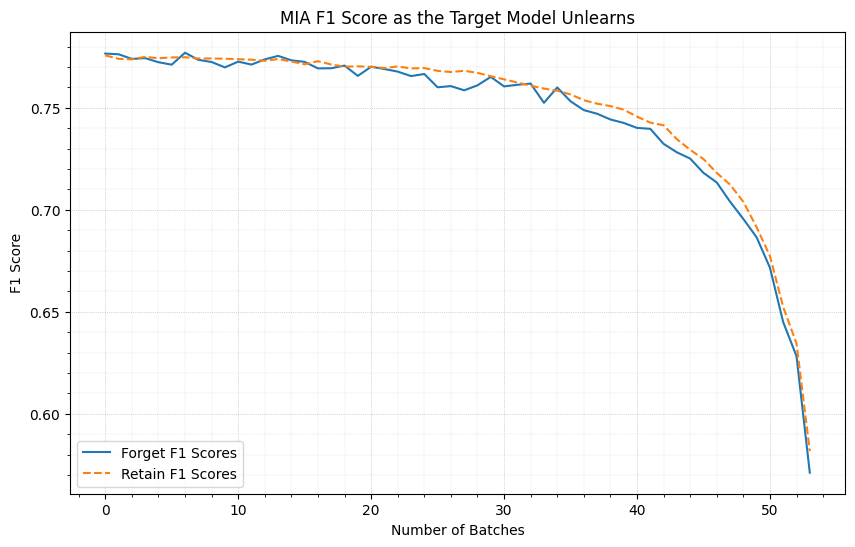

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(forget_f1s, label='Forget F1 Scores', linestyle='-')
ax.plot(retain_f1s, label='Retain F1 Scores', linestyle='--')
ax.grid(True, linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth=0.25)
ax.set_xlabel('Number of Batches')
ax.set_ylabel('F1 Score')
ax.set_title('MIA F1 Score as the Target Model Unlearns')
ax.legend(loc='lower left')

plt.show()

print accuracy

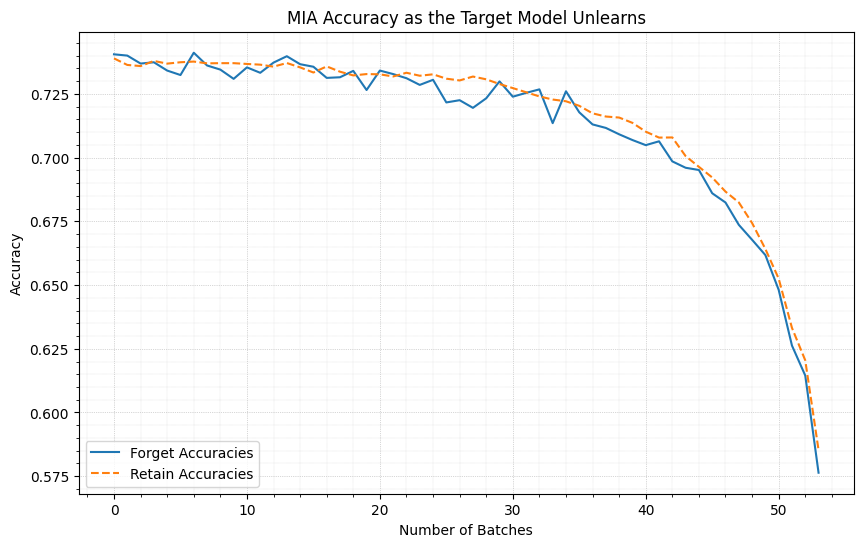

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(forget_accs, label='Forget Accuracies', linestyle='-')
ax.plot(retain_accs, label='Retain Accuracies', linestyle='--')
ax.grid(True, linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth=0.25)
ax.set_xlabel('Number of Batches')
ax.set_ylabel('Accuracy')
ax.set_title('MIA Accuracy as the Target Model Unlearns')

ax.legend(loc='lower left')

plt.show()

In [ ]:
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

set_seed(42)

def get_mia_stats(member_df, non_member_df, atk_model, tgt_model):
    X_member_df = member_df.copy()
    X_non_member_df = non_member_df.sample(n=len(X_member_df), replace=False).drop(columns=non_member_df.columns[0], axis=1)

    dataset_from_target_model_outputs = create_df_with_membership_status_using_model_outputs(tgt_model, X_member_df, X_non_member_df)

    X_attack = dataset_from_target_model_outputs.drop(columns=['membership'])
    y_attack = dataset_from_target_model_outputs['membership']

    y_attack_pred = atk_model.predict(X_attack)

    accuracy = atk_model.score(X_attack, y_attack)

    f1 = f1_score(y_attack, y_attack_pred)

    # print(f"Test F1 Score: {f1:.4f}")
    # print(f"Test Accuracy: {accuracy:.4f}")

    return f1, accuracy




# y_attack_probs = attack_model.predict_proba(X_attack)[:, 1]

# fpr, tpr, thresholds = roc_curve(y_attack, y_attack_probs)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title(f'Receiver Operating Characteristic (ROC) Curve - unlearned_full_data_target_model')
# plt.legend(loc='lower right')


# plt.text(0.7, 0.3, f'Test Accuracy: {test_accuracy:.4f}', fontsize=10, color='green')
# plt.text(0.7, 0.25, f'AUC: {roc_auc:.4f}', fontsize=10, color='blue')


# plt.show()

Random seed set as 42
(4000, 600)
(4000, 600)


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


Test F1 Score: 0.6035
Test Accuracy: 0.5975
(28800, 600)
(28800, 600)


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.9s


Test F1 Score: 0.6104
Test Accuracy: 0.6031


(0.610432322819215, 0.6031076388888889)